In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Songti SC'] # 用来正常显示中文标签，如果报错可注释掉
plt.rcParams['axes.unicode_minus'] = False

# 假设文件路径如下，请根据你的实际环境修改
DATA_DIR = '../csiro-biomass' 
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')

# 1. 读取数据
df = pd.read_csv(TRAIN_CSV)

# 2. 查看基本信息
print(f"训练集形状: {df.shape}")
print("-" * 30)
print(df.info())
print("-" * 30)
display(df.head())


训练集形状: (1785, 9)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
dtypes: float64(3), object(6)
memory usage: 125.6+ KB
None
------------------------------


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [12]:
# --- 1. 使用 pivot_table 进行更稳健的转换 ---
# 我们不再将 sample_id 作为 index，因为它不是图片的唯一标识
# aggfunc='mean' 会对分组后的值进行聚合，因为我们每组只有一个值，所以取均值就等于取那个值本身
df_wide = pd.pivot_table(df, 
                         index=['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'], 
                         columns='target_name', 
                         values='target',
                         aggfunc='mean').reset_index()

# 重命名新生成的列，使其更清晰
df_wide = df_wide.rename_axis(None, axis=1)

# --- 2. 转换日期类型 ---
df_wide['Sampling_Date'] = pd.to_datetime(df_wide['Sampling_Date'])

# --- 3. 验证转换结果 ---
print("--- 转换后的宽格式数据  ---")
print(f"数据形状 (Shape): {df_wide.shape}")
print("-" * 30)
print(df_wide.info())
print("-" * 30)
display(df_wide.head())


--- 转换后的宽格式数据  ---
数据形状 (Shape): (357, 11)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   image_path     357 non-null    object        
 1   Sampling_Date  357 non-null    datetime64[ns]
 2   State          357 non-null    object        
 3   Species        357 non-null    object        
 4   Pre_GSHH_NDVI  357 non-null    float64       
 5   Height_Ave_cm  357 non-null    float64       
 6   Dry_Clover_g   357 non-null    float64       
 7   Dry_Dead_g     357 non-null    float64       
 8   Dry_Green_g    357 non-null    float64       
 9   Dry_Total_g    357 non-null    float64       
 10  GDM_g          357 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 30.8+ KB
None
------------------------------


,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,2015-04-01,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015-09-01,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015-05-18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015-09-11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


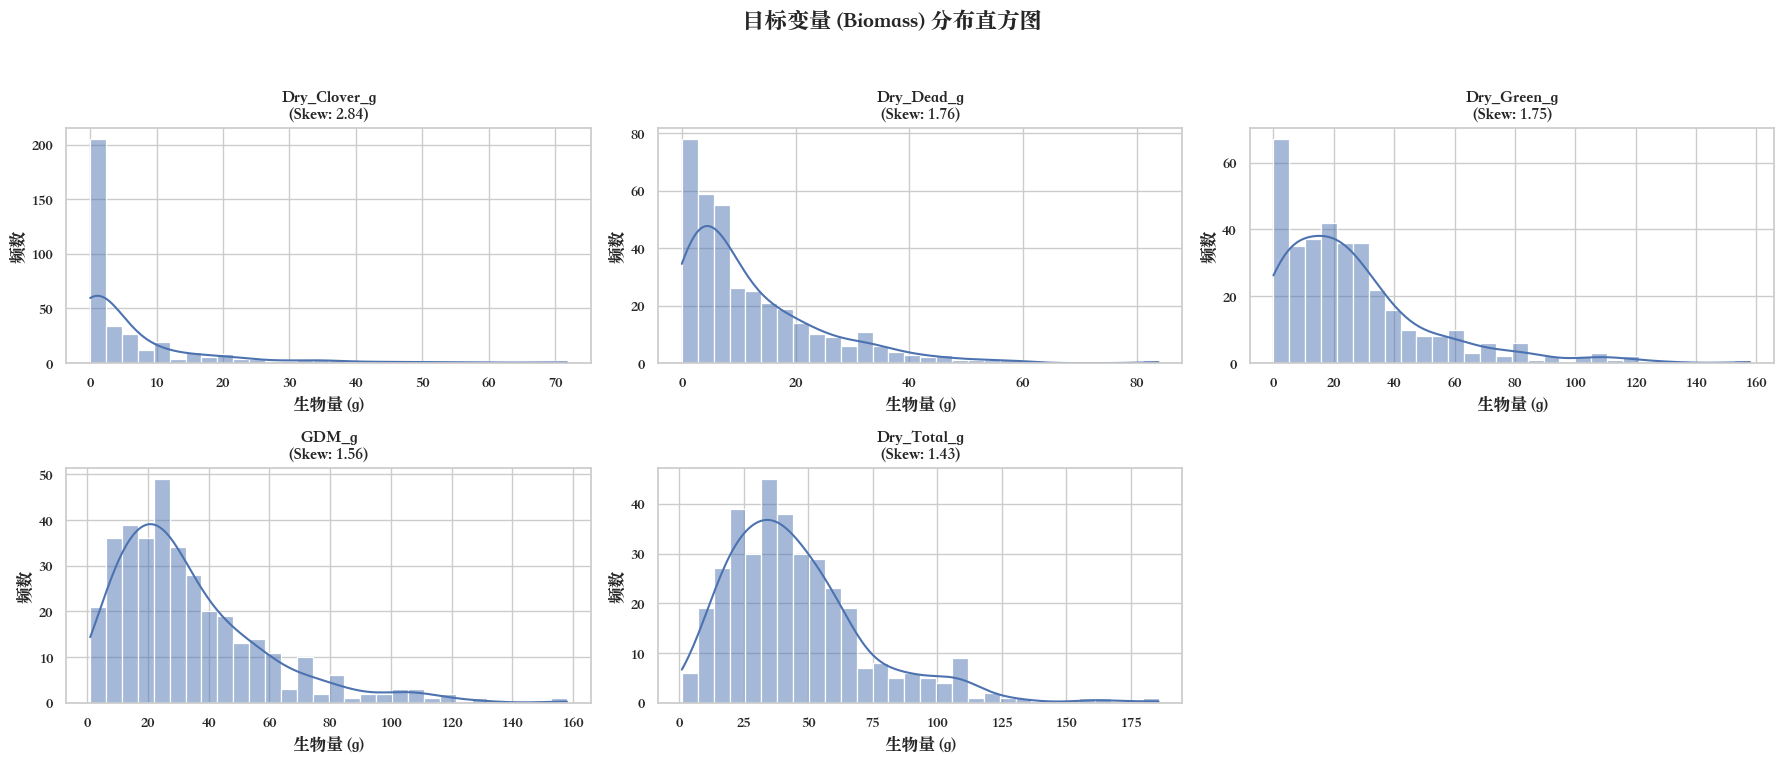

--- 各目标变量的偏度 (Skewness) ---
偏度 > 1 通常表示数据呈严重右偏分布
Dry_Clover_g    2.841982
Dry_Dead_g      1.761367
Dry_Green_g     1.751446
GDM_g           1.559033
Dry_Total_g     1.428526
dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Songti SC'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False

# 定义 5 个目标变量的列名
target_cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'GDM_g', 'Dry_Total_g']

# --- 绘制分布图 ---
plt.figure(figsize=(18, 8))
plt.suptitle("目标变量 (Biomass) 分布直方图", fontsize=16)

for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_wide[col], kde=True, bins=30)
    plt.title(f'{col}\n(Skew: {df_wide[col].skew():.2f})') # 在标题中显示偏度
    plt.xlabel('生物量 (g)')
    plt.ylabel('频数')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 打印偏度 (Skewness) 总结 ---
print("--- 各目标变量的偏度 (Skewness) ---")
print("偏度 > 1 通常表示数据呈严重右偏分布")
print(df_wide[target_cols].skew())


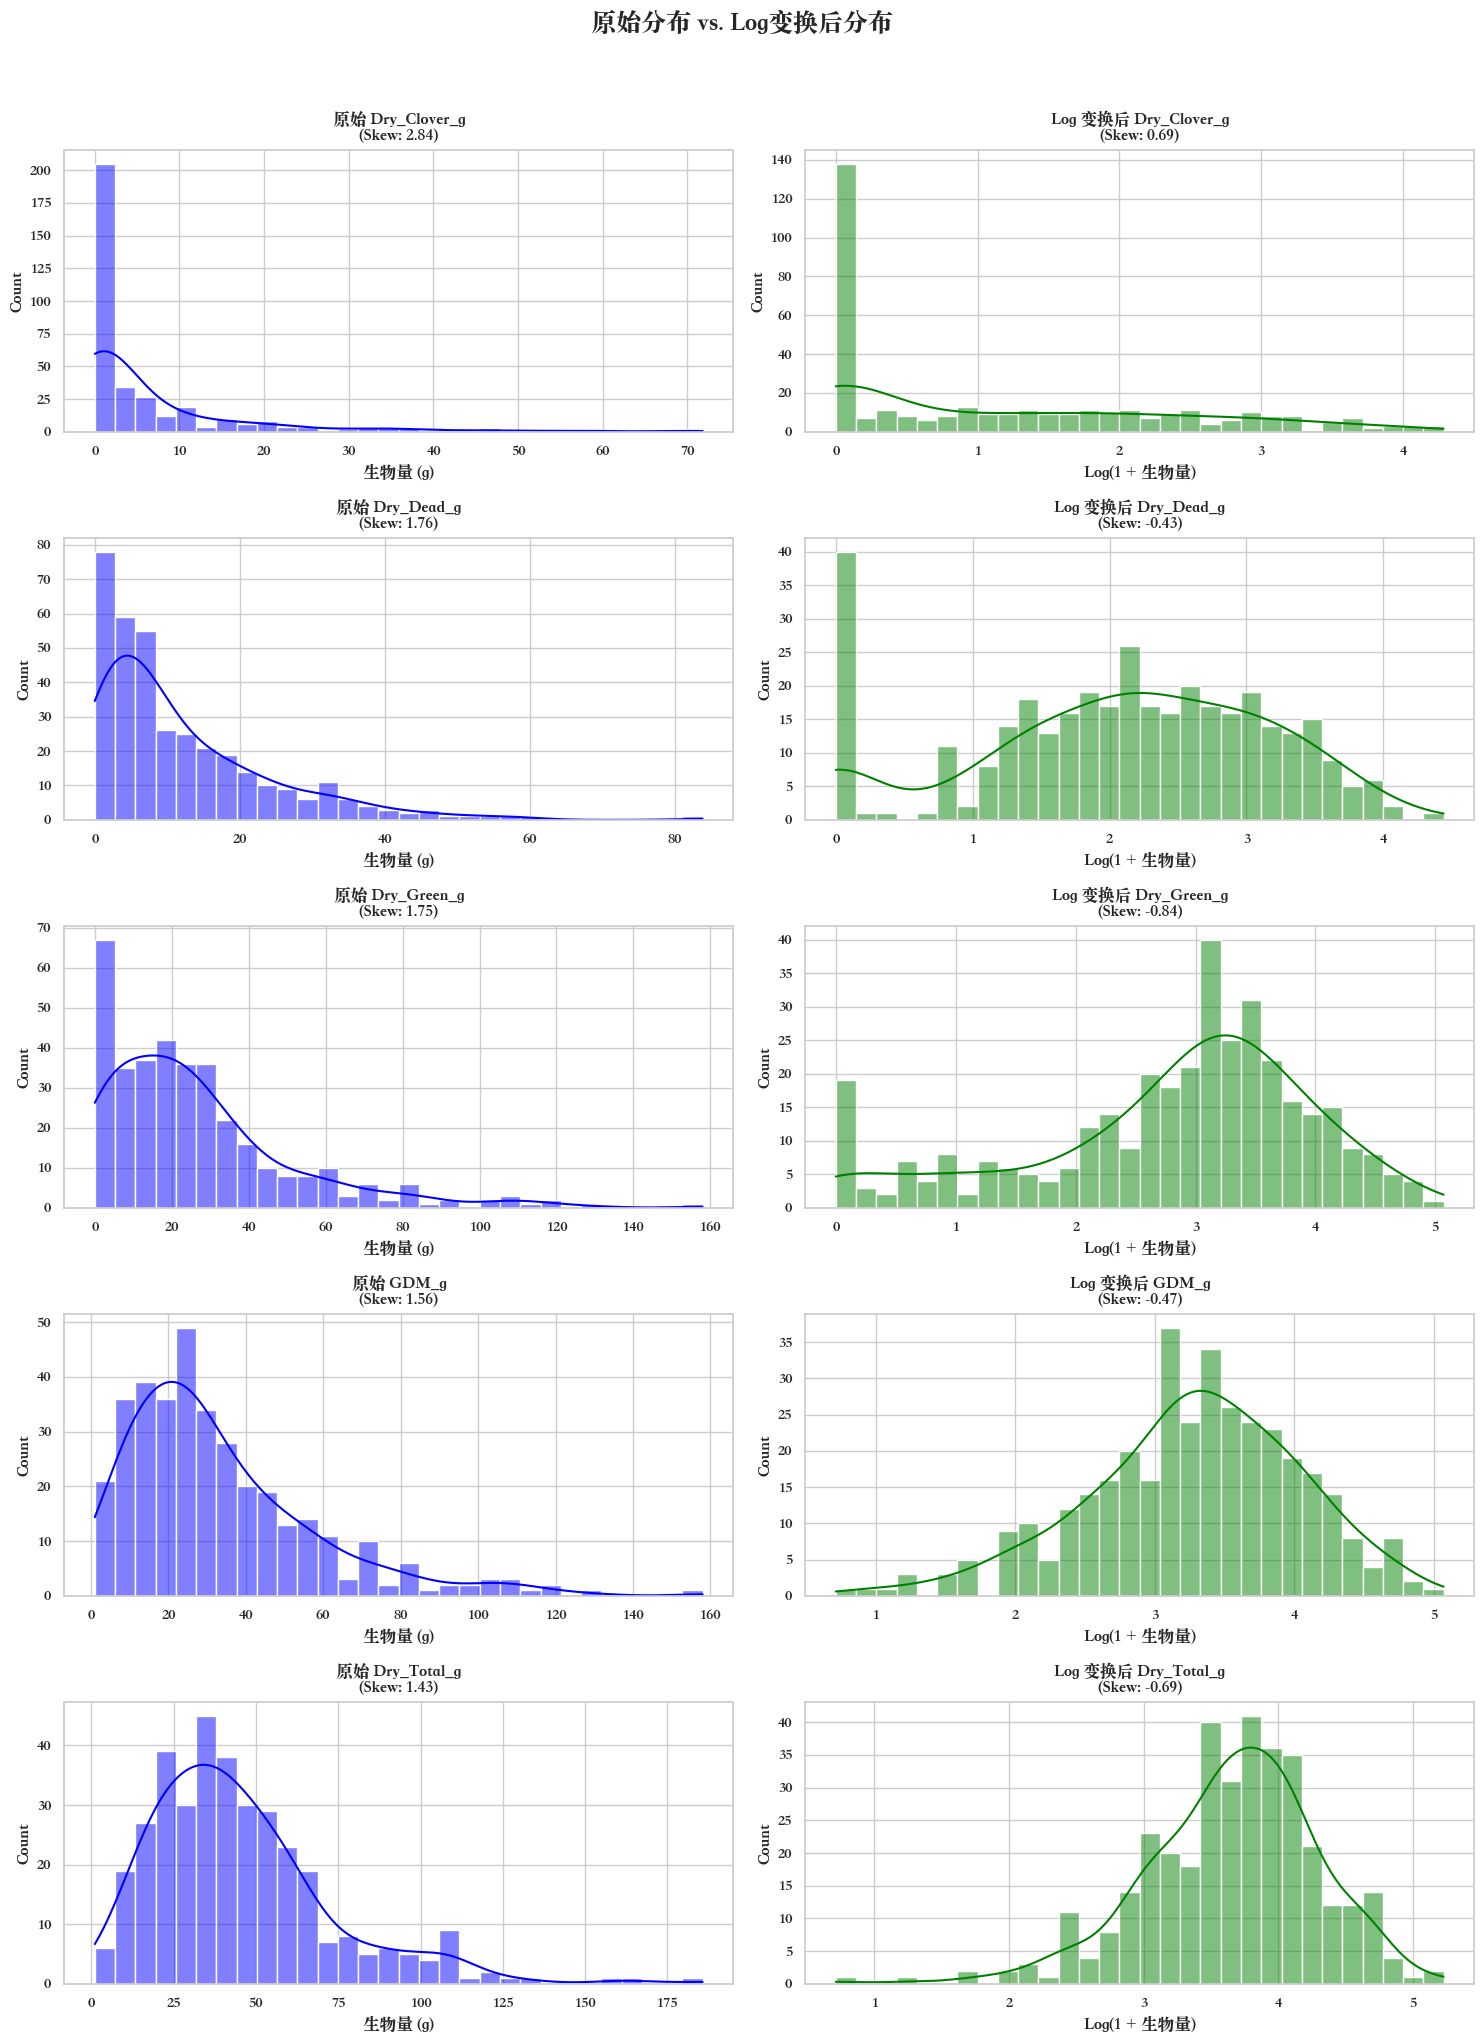

In [14]:
# --- 可视化 Log 变换的效果 ---
plt.figure(figsize=(15, 20))
plt.suptitle("原始分布 vs. Log变换后分布", fontsize=18, y=1.02)

for i, col in enumerate(target_cols):
    # 1. 绘制原始分布
    plt.subplot(5, 2, 2*i + 1)
    sns.histplot(df_wide[col], kde=True, bins=30, color='blue')
    plt.title(f"原始 {col}\n(Skew: {df_wide[col].skew():.2f})")
    plt.xlabel('生物量 (g)')

    # 2. 绘制 Log 变换后的分布
    transformed_data = np.log1p(df_wide[col])
    plt.subplot(5, 2, 2*i + 2)
    sns.histplot(transformed_data, kde=True, bins=30, color='green')
    plt.title(f"Log 变换后 {col}\n(Skew: {transformed_data.skew():.2f})")
    plt.xlabel('Log(1 + 生物量)')

plt.tight_layout()
plt.show()



# 项目第一阶段总结：数据清洗与探索性分析 (EDA)

本阶段的核心目标是**理解、清洗并准备 CSIRO 生物量预测竞赛的数据**，为后续的模型训练建立一个可靠、干净的数据基础。

### 1. 主要发现与执行的动作

我们通过一系列的探索性分析，识别出原始 `train.csv` 文件中存在的几个关键问题，并采取了相应措施：

| 发现的问题 | 描述 | 解决方案 | 最终结果 |
| :--- | :--- | :--- | :--- |
| **数据为“长格式”** | 原始数据有 `1785` 行，每张图片被拆分为 5 行，分别对应 5 个不同的目标值，不便于模型训练。 | 使用 `pandas.pivot_table` 将数据重塑为“宽格式”。 | 得到一个 `(357, 11)` 的 DataFrame (`df_wide`)，**每行代表一张唯一的图片**，并包含所有 5 个目标列。 |
| **日期类型不正确** | `Sampling_Date` 列被读取为字符串 (`object`)，无法进行时间序列分析。 | 使用 `pd.to_datetime` 将其转换为标准的日期时间格式。 | `Sampling_Date` 列的类型变为 `datetime64[ns]`，为后续提取月份等特征做好准备。 |
| **目标变量严重右偏** | 所有 5 个生物量目标（Targets）的分布都呈严重右偏（长尾分布），偏度值（Skewness）均远大于 1（例如 `Dry_Clover_g` 的偏度高达 **2.84**）。 | 对所有目标变量应用对数变换 `np.log1p()`。 | 变换后的数据分布更接近正态分布（钟形曲线），其偏度值均**接近于 0**，这有利于模型稳定训练。 |

### 2. 为下一阶段（模型训练）制定的核心策略

基于本阶段的分析，我们确定了在模型训练阶段必须遵守的关键策略：

1.  **使用清洗后的数据**：后续所有操作都必须基于我们生成的 `df_wide` DataFrame。
2.  **对数变换目标**：在训练模型时，因变量（y）必须是经过 `np.log1p()` 变换后的目标值。
3.  **预测结果还原**：模型输出预测值后，在评估或提交之前，必须使用逆运算 `np.expm1()` 将其还原到原始尺度。
4.  **特征工程提示**：`Sampling_Date` 和 `State` 这样的特征具有很强的区分度，是下一阶段特征工程的重点。

---

**阶段总结**：我们已成功将原始的、杂乱的数据转换成了一个结构清晰、格式正确、且已识别出关键数据特征（目标偏态）的可用数据集。现在，我们已经为**第二阶段：构建基准模型 (Baseline Model)** 做好了充分的准备。